# **Experiment 1: Value Model Measurements**

1. **Workload Latencies**: Measure the response times of the system.
2. **Latency Prediction Q-Errors**: Evaluate the accuracy of the system's latency prediction model by calculating Q-Errors, which quantify the deviation between predicted and actual latencies.
3. **Inference Times**: Analyze the time taken for the system to process and generate predictions, providing insights into its computational efficiency.

### **Hardware Used**

| **System**                                      | **CPU**                                       | **RAM**                                      | **Storage**                                   | **GPU**                                          | **Platform**                                     |
|-------------------------------------------------|-----------------------------------------------|----------------------------------------------|-----------------------------------------------|-------------------------------------------------|-------------------------------------------------|
| **BAO**                                         | Intel Xeon Gold 6230                         | 15GB (VM) + 256GB (CPU)                      | Not specified                                 | Tesla T4 GPU                                     | Google Cloud Platform (N1-4 VM)                 |
| **LOGER**                                       | 2× Intel Xeon Gold                           | 256GB                                        | Not specified                                 | NVIDIA RTX 3090                                  | Physical Server                                 |
| **BALSA**                                       | Microsoft Azure VMs (8 cores)                | 64GB                                         | SSD                                           | NVIDIA Tesla M60 GPU                             | Microsoft Azure                                 |
| **FASTgres**                                    | Intel Xeon Gold 6216 (12 cores)              | 92GB                                         | 1.8 TiB storage                               | Not specified                                    | Physical Server                                 |
| **train-server (Hosts PostgreSQL)**             | QEMU Virtual CPU version 2.5                 | 110GB                                        | 2.0 TiB SSD                                   | None                                            | Physical Server                                 |
| **train-gpu-server (Hosts the optimizers)**     | Intel(R) Xeon(R) Gold 5318Y                  | 377GB                                        | 1.4 TiB SSD                                   | NVIDIA RTX A6000                                  | Physical Server                                 |

### **PostgreSQL Configurations**

| **PostgreSQL Config Parameter**  | **Description** | **Default Values** | **JOB** | **Bao** | **Balsa** | **LOGER** | **Our Framework** |
|----------------------------------|----------------|------------------|-------------|-------------|-----------------------|-------------|----------------|
| **Join Order** |  |  |  |  |  |  |  |
| geqo_threshold | Sets the threshold for Genetic Query Optimizer (GEQO) to be used | 12 | 18 |  |  | 2 or 1,024 |  |
| geqo | Enables or disables GEQO, which helps optimize complex queries | on |  |  | off | off | off |
| **Working Memory** |  |  |  |  |  |  |  |
| work_mem | Memory allocated for each query operation (e.g., sorting, hashing) | 4 MB | 2 GB |  | 4 GB | | 4 GB |
| shared_buffers | Memory used for PostgreSQL's buffer cache to reduce disk I/O | 128 MB | 4 GB | 4 GB | 32 GB | 64 GB | 32 GB |
| temp_buffers | Memory allocated for temporary tables during a session | 8 MB |  |  | 32 GB |  | 32 GB |
| effective_cache_size | Estimated memory available for caching disk pages | 4 GB | 32 GB |  |  |  | 64 GB |
| **Parallelization** |  |  |  |  |  |  |  |
| max_parallel_workers | Maximum number of parallel workers allowed | 8 |  |  |  | 1 | 8 |
| max_parallel_workers_per_gather | Maximum parallel workers per `Gather` node in a query plan | 8 |  |  |  | 1 | 8 |
| max_worker_processes | Maximum background worker processes allowed | 2 |  |  | 8 |  | 8 |
| **Scan Types** |  |  |  |  |  |  |  |
| enable_bitmapscan | Enables bitmap scans for efficient index-based retrieval | on |  | | off |  | on |
| enable_tidscan | Enables TID scans, which use tuple IDs for direct row lookups | on |  |  | off |  | on |


## **Benchmarks Used**

### **1. JOB and its Variants**

#### **Join Order Benchmark (Default)**

- Evaluates the efficiency of database query optimizers, focusing on join order optimization and cardinality estimation accuracy.
- 21 Tables, 6 Columns per Table on Average, 3.6 GB in size, 113 Queries in total, 8 average Joins per query

## **2. TPC-H and Its Variants**  

### **TPC-H-NO-NESTED-QUERIES**  
- Uses **templates 3, 5, 12, and 14** for training and **template 10** for testing, with **10 queries per template**.  
- Excludes queries containing **nested subqueries** in either the **FROM** or **WHERE** clause.  
- Templates **7, 8, and 13** are excluded due to their reliance on these nested structures, which **LOGER** and **FASTgres** cannot process.  
- **Example of Banned Queries:**  

  **1. Nested FROM Clause (Disallowed)**  
  ```sql
  SELECT o_orderkey, revenue
  FROM (
      SELECT l_orderkey AS o_orderkey, SUM(l_extendedprice) AS revenue
      FROM lineitem
      GROUP BY l_orderkey
  ) AS subquery
  WHERE revenue > 100000;
  ```
  - This query is excluded because it **uses a subquery in the FROM clause (nested FROM)**.  

  **2. Nested WHERE Clause (Disallowed)**  
  ```sql
  SELECT l_orderkey
  FROM lineitem
  WHERE l_extendedprice > (
      SELECT AVG(l_extendedprice)
      FROM lineitem
  );
  ```
  - This query is excluded because it **contains a subquery in the WHERE clause**.  

- **Compatible with:**  
  - BAO  
  - Balsa  
  - FASTgres  
  - LOGER  

### **3. TPC-DS**  

### **3.1 TPC-DS-SIMPLE** (originates from *LOGER*)
- Only queries in SPJ Format
- Uses **15 templates for training** and **5 templates for testing**, ensuring that all tables in the testing workload appear in the training workload.  
- Generates **3 queries per template** for both training and testing.  
- **Training Templates:** 3, 7, 12, 20, 26, 37, 42, 43, 50, 55, 62, 84, 91, 96, 99  
- **Testing Templates:** 18, 27, 52, 82, 98  
- **Compatible with:**
  - BAO
  - LOGER  
  - FASTgres (WIP)  


In [14]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgb, to_hex
import colorsys

# Constants
benchmarks = ['JOB', 'TPC-H', 'TPC-DS']
optimizers = ['Postgres', 'NEO', 'BAO', 'LOGER', 'FASTgres', 'LERO']
qerror_optimizers = ['NEO', 'BAO', 'LOGER']
RUNS = 3  # Number of runs for each optimizer

# Restructured global data storage
latencies = {benchmark: {run: {} for run in range(RUNS)} for benchmark in benchmarks}
predictions = {benchmark: {run: {} for run in range(RUNS)} for benchmark in benchmarks}
inference_times = {benchmark: {run: {} for run in range(RUNS)} for benchmark in benchmarks}
q_errors = {benchmark: {run: {} for run in range(RUNS)} for benchmark in benchmarks}

from pathlib import Path
try:
    # Works when running from a .py file
    REPO_ROOT = Path(__file__).resolve()
except NameError:
    # Fallback for notebooks — use current working directory
    REPO_ROOT = Path.cwd().resolve()
while REPO_ROOT.name != "Learned-Optimizers-Benchmarking-Suite" and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent

base_dir = f'{REPO_ROOT}/experiments/experiment1/'
# Each test dir contains subdirectories for each run, 
# then each run contains subdirectories for each queryID, 
# then each queryID contains subdirectories for each optimizer
# Each optimizer subdirectory contains a file with the results

benchmark_dirs = {
    'JOB': os.path.join(base_dir, 'job', 'test'),
    'TPC-H': os.path.join(base_dir, 'tpch', 'test'),
    'TPC-DS': os.path.join(base_dir, 'tpcds', 'test')
}

In [15]:
def collect_results(test_dir):
    for benchmark, test_dir in benchmark_dirs.items():
        for run in range(RUNS):
            run_dir = os.path.join(test_dir, f'run{run + 1}')
            if not os.path.exists(run_dir): continue
            for query_id in os.listdir(run_dir):
                query_dir = os.path.join(run_dir, query_id)
                if not os.path.isdir(query_dir): continue
                if query_id not in latencies[benchmark][run]:
                    latencies[benchmark][run][query_id] = {}
                    predictions[benchmark][run][query_id] = {}
                    inference_times[benchmark][run][query_id] = {}
                    q_errors[benchmark][run][query_id] = {}
                for optimizer in optimizers:
                    plan_file = ''
                    optimizer_dir = os.path.join(query_dir, optimizer)
                    if optimizer == 'Postgres':
                        plan_file = os.path.join(query_dir, 'classic_qep.json')
                    else:
                        plan_file = os.path.join(optimizer_dir, f'{query_id}_{optimizer.lower()}_plan.json')
                    if not os.path.exists(plan_file): continue
                    with open(plan_file, 'r') as f:
                        data = json.load(f)
                        bao_metrics = {}
                        if optimizer == "BAO" and isinstance(data, list):
                            bao_metrics = data[0].get('Bao', {})
                            data = data[1]
                    exec_time = (data[0].get('Execution Time') if isinstance(data, list) else data.get('Execution Time'))
                    if isinstance(exec_time, (str, type(None))): exec_time = float(exec_time or 0)
                    latencies[benchmark][run][query_id][optimizer] = exec_time / 1000.0
                    if optimizer in ["Postgres", "BAO", "LERO"]:
                        plan_time = (data[0].get('Planning Time') if isinstance(data, list) else data.get('Planning Time'))
                        if isinstance(plan_time, (str, type(None))): plan_time = float(plan_time or 0)
                        inference_times[benchmark][run][query_id][optimizer] = plan_time / 1000.0
                        if optimizer == "BAO":
                            prediction = bao_metrics.get('Bao prediction')
                            if isinstance(prediction, str): prediction = json.loads(prediction)
                            predictions[benchmark][run][query_id][optimizer] = prediction
                            if prediction and exec_time:
                                q_errors[benchmark][run][query_id][optimizer] = max(prediction / exec_time, exec_time / prediction)
                    elif optimizer in ["LOGER", "NEO", "FASTgres"]:
                        metrics_file = os.path.join(optimizer_dir, f'{query_id}_{optimizer.lower()}_metrics.json')
                        if os.path.exists(metrics_file):
                            with open(metrics_file, 'r') as mf:
                                metrics_data = json.load(mf)
                                plan_time_key = 'inference_time' if optimizer in ["LOGER", "NEO"] else 'forward_time'
                                plan_time = metrics_data.get(plan_time_key, 0)
                                if isinstance(plan_time, (str, type(None))): plan_time = float(plan_time or 0)
                                inference_times[benchmark][run][query_id][optimizer] = plan_time / 1000.0
                                if optimizer in ["LOGER", "NEO"]:
                                    prediction = metrics_data.get('predicted_latency', 0)
                                    if prediction < 0:
                                        prediction = -prediction
                                    if isinstance(prediction, (str, type(None))): prediction = float(prediction or 0)
                                    # prediction = prediction / 1000.0 if optimizer == "LOGER" else prediction
                                    predictions[benchmark][run][query_id][optimizer] = prediction
                                    if prediction and exec_time > 0:
                                        q_errors[benchmark][run][query_id][optimizer] = max(prediction / exec_time, exec_time / prediction)

collect_results(benchmark_dirs)

In [16]:
print("Results collected successfully.")
# Print JOB-Related Results
print("JOB Benchmark Results:")
print("Latencies:")
print(latencies['JOB'])
print("Predictions:")
print(predictions['JOB'])
print("Inference Times:")
print(inference_times['JOB'])
print("Q-errors:")
print(q_errors['JOB'])

Results collected successfully.
JOB Benchmark Results:
Latencies:
{0: {'16b': {'Postgres': 18.299045999999997, 'NEO': 63.65876, 'BAO': 5.861217, 'LOGER': 5.583018, 'FASTgres': 8.289295, 'LERO': 18.723751}, '13a': {'Postgres': 1.6328420000000001, 'NEO': 18.480138999999998, 'BAO': 1.721851, 'LOGER': 1.5590229999999998, 'FASTgres': 2.4498539999999998, 'LERO': 1.937913}, '6b': {'Postgres': 0.364282, 'NEO': 38.00445, 'BAO': 0.374661, 'LOGER': 0.172012, 'FASTgres': 2.981541, 'LERO': 0.463353}, '3b': {'Postgres': 0.26222, 'NEO': 4.161156, 'BAO': 0.177328, 'LOGER': 0.09145099999999999, 'FASTgres': 0.154599, 'LERO': 0.243157}, '13d': {'Postgres': 2.820608, 'NEO': 16.685226999999998, 'BAO': 2.098728, 'LOGER': 2.421, 'FASTgres': 4.3816109999999995, 'LERO': 6.050033999999999}, '26c': {'Postgres': 4.646694999999999, 'NEO': 14.39092, 'BAO': 2.0471120000000003, 'LOGER': 0.619904, 'FASTgres': 2.975491, 'LERO': 1.736001}, '11c': {'Postgres': 0.356301, 'NEO': 11.111077, 'BAO': 0.223723, 'LOGER': 0.14659

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgb, to_hex

# Define color palette for optimizers
optimizer_colors = {
    'Postgres': '#1f77b4',  # Blue
    'NEO': '#ff7f0e',       # Orange
    'BAO': '#2ca02c',       # Green
    'LOGER': '#d62728',     # Red
    'FASTgres': '#9467bd',  # Purple
    'LERO': '#8c564b'       # Brown
}

# Define patterns for each optimizer (optional)
patterns = {
    'Postgres': '',       # Solid (no hatch)
    'NEO': '//',       # Forward slashes
    'BAO': '\\\\',      # Backward slashes (backslashes must be escaped)
    'LOGER': '||',       # Vertical lines
    'FASTgres': '--',      # Horizontal lines
    'LERO': 'OO'        # Large circles
}

import matplotlib.ticker as ticker

# Create output directory
output_dir = f'{REPO_ROOT}/experiments/experiment1/plots/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [18]:
import matplotlib.patches as mpatches
import numpy as np

def create_stacked_bar_legend(save_path="plots/grouped_stacked_legend.pdf"):
    """
    Creates and saves a standalone legend for the stacked bar plot.
    """
    print("\nGenerating standalone stacked bar legend...")
    plt.rcParams.update({'font.size': 28}) # Match the original legend font size

    # Recreate the handles exactly as in the original plot function
    # NOTE: This relies on the global variables: optimizer_colors, patterns, optimizers
    optimizer_handles = [
        mpatches.Patch(facecolor=optimizer_colors[o], edgecolor='black', hatch=patterns[o], label=o)
        for o in optimizers
    ]
    exec_patch = mpatches.Patch(facecolor='gray', edgecolor='black', label='Execution Time')
    inf_patch = mpatches.Patch(facecolor='lightgray', edgecolor='black', label='Inference Time')
    
    all_handles = optimizer_handles + [inf_patch, exec_patch]

    # Create a new, temporary figure to hold the legend
    fig, ax = plt.subplots(figsize=(10, 2)) # The size is arbitrary due to tight bbox
    ax.axis('off') # Make the plot area invisible

    # Create the legend, centered on the figure
    # ncol = int(np.ceil(len(all_handles) / 2)) # Arrange in 2 rows
    legend = fig.legend(
        handles=all_handles,
        loc='center',
        ncol=len(all_handles),
        frameon=True,
        fontsize=28,
        handlelength=2.5,
        handleheight=1.5
    )

    # Ensure the output directory exists
    output_dir = os.path.dirname(save_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the figure, cropping to only the legend's bounding box
    fig.savefig(
        save_path,
        bbox_inches='tight',
        bbox_extra_artists=[legend]
    )
    plt.close(fig) # Close the figure to free up memory
    print(f"Saved standalone legend to: {save_path}")

create_stacked_bar_legend()


Generating standalone stacked bar legend...
Saved standalone legend to: plots/grouped_stacked_legend.pdf


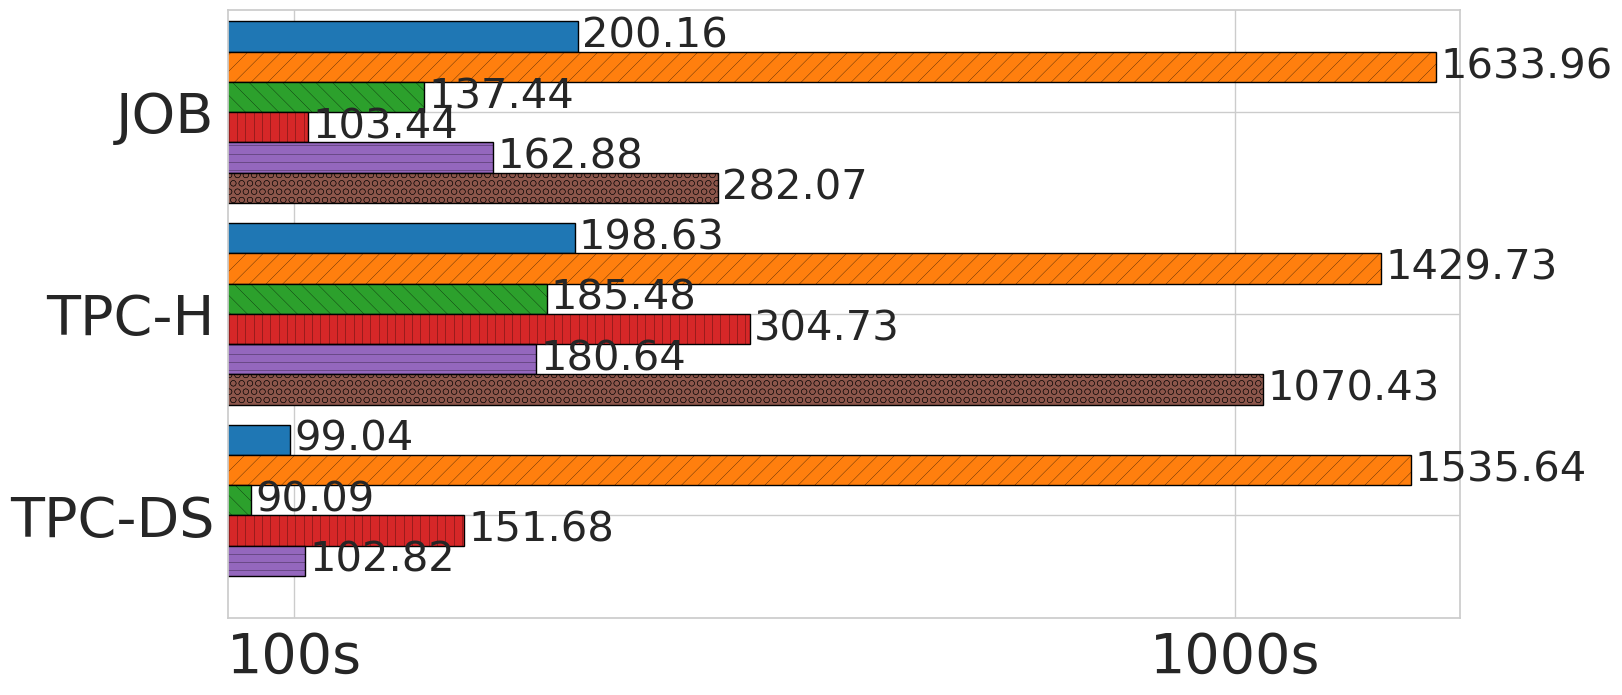

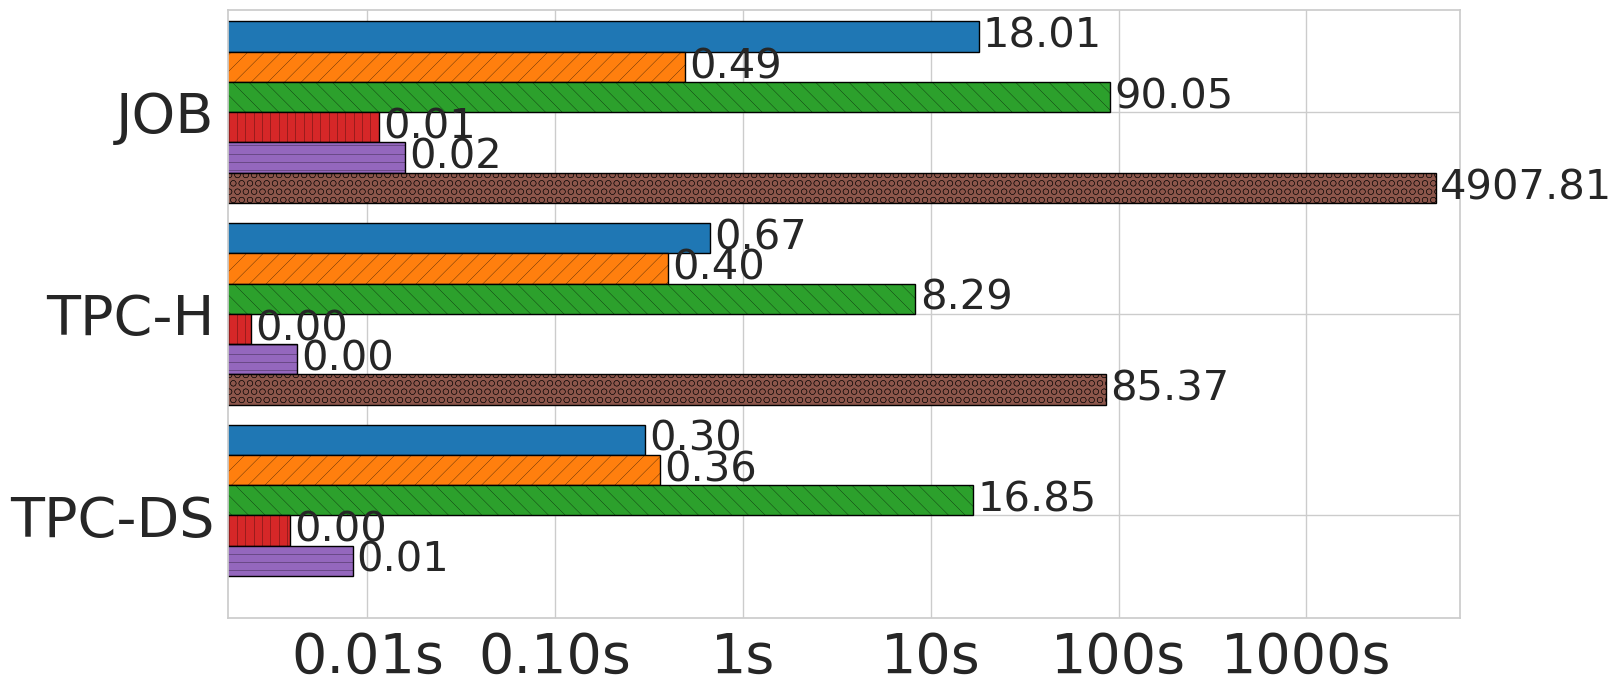

In [19]:
def create_plots_inverted(data_dict, xlabel, title_suffix, log_scale=False, selected_optimizers=None):
    """
    Horizontal version of create_plots with inverted axes.
    Legend is a single row at the top, and gaps between benchmarks are reduced.
    """
    plt.figure(figsize=(14, 8))
    plt.rcParams.update({'font.size': 40})

    # This can control the thickness of the hatch lines, making them appear less prominent
    plt.rcParams['hatch.linewidth'] = 0.2

    benchmarks = list(data_dict.keys())
    benchmarks.reverse()
    y = np.arange(len(benchmarks))
    opt_list = selected_optimizers if selected_optimizers else optimizers
    num_optimizers = len(opt_list)

    group_height = 0.9
    bar_height = group_height / num_optimizers

    multiplier = 0
    for optimizer in opt_list:
        values = []
        # Loop in the reversed benchmark order for correct data alignment
        for benchmark in benchmarks:
            run_totals = []
            for run in data_dict.get(benchmark, {}).values():
                run_total = 0
                query_count = 0
                for query_data in run.values():
                    if optimizer in query_data:
                        run_total += query_data[optimizer]
                        query_count += 1
                if query_count > 0:
                    run_totals.append(run_total)
            avg_value = np.mean(run_totals) if run_totals else 0
            values.append(avg_value)

        # --- CHANGE 1: Reorder bars to match legend order (top-to-bottom) ---
        # The original calculation started from the bottom of the group and added bars upwards.
        # This new calculation starts from the top of the group and adds bars downwards,
        # so the first optimizer in the list appears at the top.
        position = y + group_height / 2 - bar_height / 2 - bar_height * multiplier
        
        bars = plt.barh(position, values, bar_height,
                        label=optimizer,
                        color=optimizer_colors.get(optimizer, 'gray'),
                        hatch=patterns.get(optimizer, ''),
                        edgecolor='black')
        plt.bar_label(bars, padding=3, fmt='%.2f', fontsize=30)
        multiplier += 1

    plt.xticks(fontsize=40)
    plt.yticks(y, benchmarks, fontsize=40)
    plt.xlabel('') # Restored the xlabel for clarity

    # plt.title(title_suffix, y=1.15) # Added back a title, positioned above the legend

    if log_scale:
        plt.xscale('log')
        ax = plt.gca()
        ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=[1.0], numticks=10))
        ax.xaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, _: f"{int(x)}s" if x >= 1 else f"{x:.2f}s")
        )

    plt.tight_layout()
    ax.margins(0.02)
    # --- CHANGE 2: Save the plot as a PDF file ---
    # Matplotlib determines the format from the file extension.
    # We also remove dpi=300 as it's not relevant for vector formats like PDF.
    output_file_pdf = os.path.join(output_dir, f'{title_suffix.lower().replace(" ", "_")}_horizontal.pdf')
    plt.subplots_adjust(left=0.1, right=0.98, top=0.88, bottom=0.12)
    plt.savefig(output_file_pdf, bbox_inches='tight')
    plt.show()


create_plots_inverted(latencies, "Latency (s)", "Execution Latency", log_scale=True)
create_plots_inverted(inference_times, "Inference Time (s)", "Optimizer Inference Time", log_scale=True)

/tmp/ipykernel_660703/1283213349.py:141: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=36)


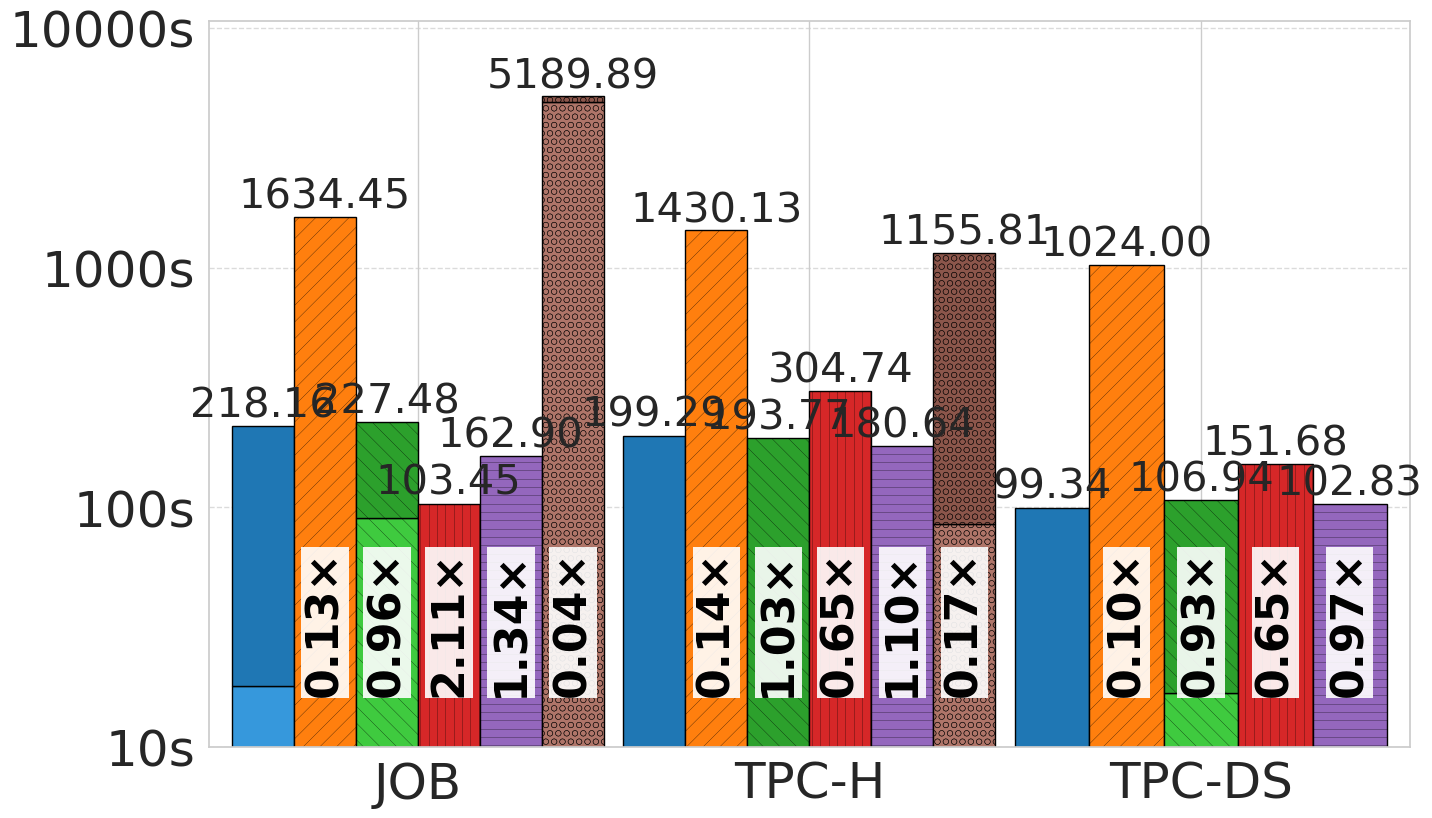

In [20]:
def create_stacked_bar_plot(latency_dict, inference_dict, title="Total Time (Execution + Inference)", log_scale=True):
    import colorsys
    from matplotlib.colors import to_rgb, to_hex
    import matplotlib.patches as mpatches
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams.update({'font.size': 26})
    
    # --- Color & pattern config ---
    base_colors = {
        'Postgres': '#1f77b4',
        'NEO': '#ff7f0e',
        'BAO': '#2ca02c',
        'LOGER': '#d62728',
        'FASTgres': '#9467bd',
        'LERO': '#8c564b'
    }

    def adjust_lightness(color, amount=0.5):
        try:
            c = colorsys.rgb_to_hls(*to_rgb(color))
            return to_hex(colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2]))
        except:
            return color

    benchmarks = list(latency_dict.keys())
    optimizer_set = optimizers  # global
    n_optimizers = len(optimizer_set)

    group_width = 0.95
    bar_width = group_width / n_optimizers
    x = np.arange(len(benchmarks))

    fig, ax = plt.subplots(figsize=(14, 8))
    legend_labels = {"Execution Time": False, "Inference Time": False}

    # --- CHANGE #1: Loop through benchmarks first, not optimizers ---
    for j, benchmark in enumerate(benchmarks):
        
        # --- CHANGE #2: Find which optimizers are available FOR THIS BENCHMARK ---
        available_optimizers = []
        for opt in optimizer_set:
            has_data = any(
                opt in qdata
                for run in latency_dict[benchmark].values()
                for qdata in run.values()
            )
            if has_data:
                available_optimizers.append(opt)
        
        # --- CHANGE #3: Calculate bar width and offsets based on AVAILABLE optimizers ---
        n_optimizers_this_group = len(available_optimizers)
        if n_optimizers_this_group == 0:
            continue # Skip this benchmark if it has no data at all
            
        bar_width = group_width / n_optimizers_this_group

        # --- CHANGE #4: Loop through the available optimizers to plot them ---
        for i, optimizer in enumerate(available_optimizers):
            offset = (i - n_optimizers_this_group / 2) * bar_width + bar_width / 2
            
            # --- The data extraction logic is now guaranteed to find data ---
            exec_times = []
            inf_times = []

            for run in latency_dict[benchmark].values():
                for qdata in run.values():
                    if optimizer in qdata:
                        exec_times.append(qdata[optimizer])
            for run in inference_dict[benchmark].values():
                for qdata in run.values():
                    if optimizer in qdata:
                        inf_times.append(qdata[optimizer])

            avg_exec = np.sum(exec_times) / 3 if exec_times else 0
            avg_inf = np.sum(inf_times) / 3 if inf_times else 0
            total = avg_exec + avg_inf
            color = base_colors.get(optimizer, '#999999')
            light_color = adjust_lightness(color, 1.3)
            hatch = patterns.get(optimizer, '')
            xpos = x[j] + offset
            ypos = avg_inf + avg_exec / 3

            # Draw bars
            ax.bar(xpos, avg_inf,
                   width=bar_width,
                   color=light_color,
                   edgecolor='black',
                   hatch=hatch,
                   label='Inference Time' if not legend_labels["Inference Time"] else "")
            legend_labels["Inference Time"] = True

            ax.bar(xpos, avg_exec,
                   width=bar_width,
                   bottom=avg_inf,
                   color=color,
                   edgecolor='black',
                   hatch=hatch,
                   label='Execution Time' if not legend_labels["Execution Time"] else "")
            legend_labels["Execution Time"] = True

            # Annotate total time on top
            if total > 0:
                ax.text(
                    xpos, avg_inf + avg_exec + 1,
                    f"{total:.2f}",
                    ha='center',
                    va='bottom',
                    fontsize=30
                )

            # Compute and display speedup UNDER the x-axis
            pg_exec = sum([
                qdata.get('Postgres', 0)
                for run in latency_dict[benchmark].values()
                for qdata in run.values()
            ]) / 3
            pg_inf = sum([
                qdata.get('Postgres', 0)
                for run in inference_dict[benchmark].values()
                for qdata in run.values()
            ]) / 3
            pg_total = pg_exec + pg_inf if (pg_exec + pg_inf) > 0 else 1e-6

            if optimizer != 'Postgres' and total > 0:
                speedup = pg_total / total
                ax.text(
                    xpos, 33,
                    f"{speedup:.2f}×",
                    ha='center',
                    va='center',
                    fontsize=32,
                    fontweight='bold',
                    color='black',
                    bbox=dict(facecolor='white', edgecolor='none', pad=1.5, alpha=0.9),
                    rotation=90
                )

    # Adjust axes
    ax.set_xticks(x)
    ax.set_xticklabels(benchmarks, fontsize=36)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=36)
    ax.set_title('')

    if log_scale:
        ax.set_yscale('log')
        ax.set_ylim(bottom=10)
        # Major ticks only at powers of 10
        ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=[1.0], numticks=10))
        # Optional: minor ticks at 2 and 5 within each decade
        ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=[2.0, 5.0], numticks=10))
        # Pretty formatting (seconds vs. generic values)
        ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(lambda y, _: f"{int(y)}s" if y >= 1 else f"{y:.2f}s")
        )
    else:
        ax.set_ylim(bottom=-0.3)  # leave space for speedup labels

    # Legend
    optimizer_handles = [
        mpatches.Patch(facecolor=base_colors[o], edgecolor='black', hatch=patterns[o], label=o)
        for o in optimizer_set
    ]
    exec_patch = mpatches.Patch(facecolor='gray', edgecolor='black', label='Execution Time')
    inf_patch = mpatches.Patch(facecolor='lightgray', edgecolor='black', label='Inference Time')
    all_handles = optimizer_handles + [inf_patch, exec_patch]
    ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(pad=0.0)
    ax.margins(0.02)
    output_file = os.path.join(output_dir, 'grouped_stacked_latency_inference.pdf')
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()

create_stacked_bar_plot(latencies, inference_times)

In [21]:
# Sort and print JOB inference times for postgres
pg_inference_times = []
for run in inference_times['JOB'].values():
    for qdata in run.values():
        if 'Postgres' in qdata:
            pg_inference_times.append(qdata['Postgres'])
pg_inference_times.sort(reverse=True)
print("Sorted Postgres Inference Times for JOB (s):")
print(pg_inference_times)

Sorted Postgres Inference Times for JOB (s):
[4.83776, 4.693872000000001, 4.445541, 4.255072, 4.136667999999999, 3.7373000000000003, 3.6476669999999998, 3.125723, 3.108918, 0.5772569999999999, 0.5747709999999999, 0.558275, 0.55096, 0.461504, 0.459, 0.457341, 0.456261, 0.454769, 0.454459, 0.441866, 0.437358, 0.43172699999999997, 0.35951799999999995, 0.349853, 0.343049, 0.243785, 0.239457, 0.168093, 0.154944, 0.154517, 0.154485, 0.153445, 0.153242, 0.150699, 0.150122, 0.147314, 0.14681, 0.14615, 0.144406, 0.142293, 0.14193199999999997, 0.140942, 0.140923, 0.11214199999999999, 0.11047799999999999, 0.108291, 0.10547799999999999, 0.10533, 0.104151, 0.103522, 0.10342100000000001, 0.10225400000000001, 0.10081999999999999, 0.100537, 0.100161, 0.09989, 0.09485500000000001, 0.08505700000000001, 0.084792, 0.082329, 0.08229, 0.080788, 0.08062699999999999, 0.080348, 0.077171, 0.075369, 0.07533799999999999, 0.074352, 0.07248600000000001, 0.065066, 0.06385, 0.06357399999999999, 0.06351899999999999, 0

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker

def prepare_metric_data(metric_dict, metric_name):
    """Convert nested metric dictionary to DataFrame suitable for boxplots"""
    data = []
    for benchmark in benchmarks:
        for run in range(RUNS):
            for query_id, query_data in metric_dict[benchmark][run].items():
                for optimizer, value in query_data.items():
                    data.append({
                        'Benchmark': benchmark,
                        'Optimizer': optimizer,
                        'Run': run,
                        'Query': query_id,
                        metric_name: value
                    })
    return pd.DataFrame(data)

# Prepare DataFrames for each metric
latency_df = prepare_metric_data(latencies, 'Latency')
inference_df = prepare_metric_data(inference_times, 'InferenceTime')
qerror_df = prepare_metric_data(q_errors, 'QError')

In [23]:
import matplotlib.patches as mpatches

def create_boxplot_legend(optimizer_list, save_path):
    """
    Creates and saves a standalone legend for the boxplots.
    """
    plt.rcParams.update({'font.size': 28}) # Match the original legend font size

    # Recreate the legend handles using the provided optimizer list
    # Relies on global variables: optimizer_colors, patterns
    legend_handles = [
        mpatches.Patch(facecolor=optimizer_colors[opt], hatch=patterns.get(opt, ''), label=opt, edgecolor='black')
        for opt in optimizer_list
    ]

    # Create a new, temporary figure to hold the legend
    fig, ax = plt.subplots(figsize=(10, 2)) # Size is arbitrary
    ax.axis('off') # Make the plot area invisible

    # Create the legend, centered on the figure
    legend = fig.legend(
        handles=legend_handles,
        loc='center',
        ncol=len(optimizer_list),
        frameon=True,
    )

    # Ensure the output directory exists
    output_dir = os.path.dirname(save_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the figure, cropping to only the legend's bounding box
    fig.savefig(
        save_path,
        format='pdf',
        bbox_inches='tight',
        bbox_extra_artists=[legend]
    )
    plt.close(fig)

create_boxplot_legend(
    optimizer_list=optimizers,
    save_path=os.path.join(output_dir, 'qerror_legend.pdf')
)

Generating combined latency plot...


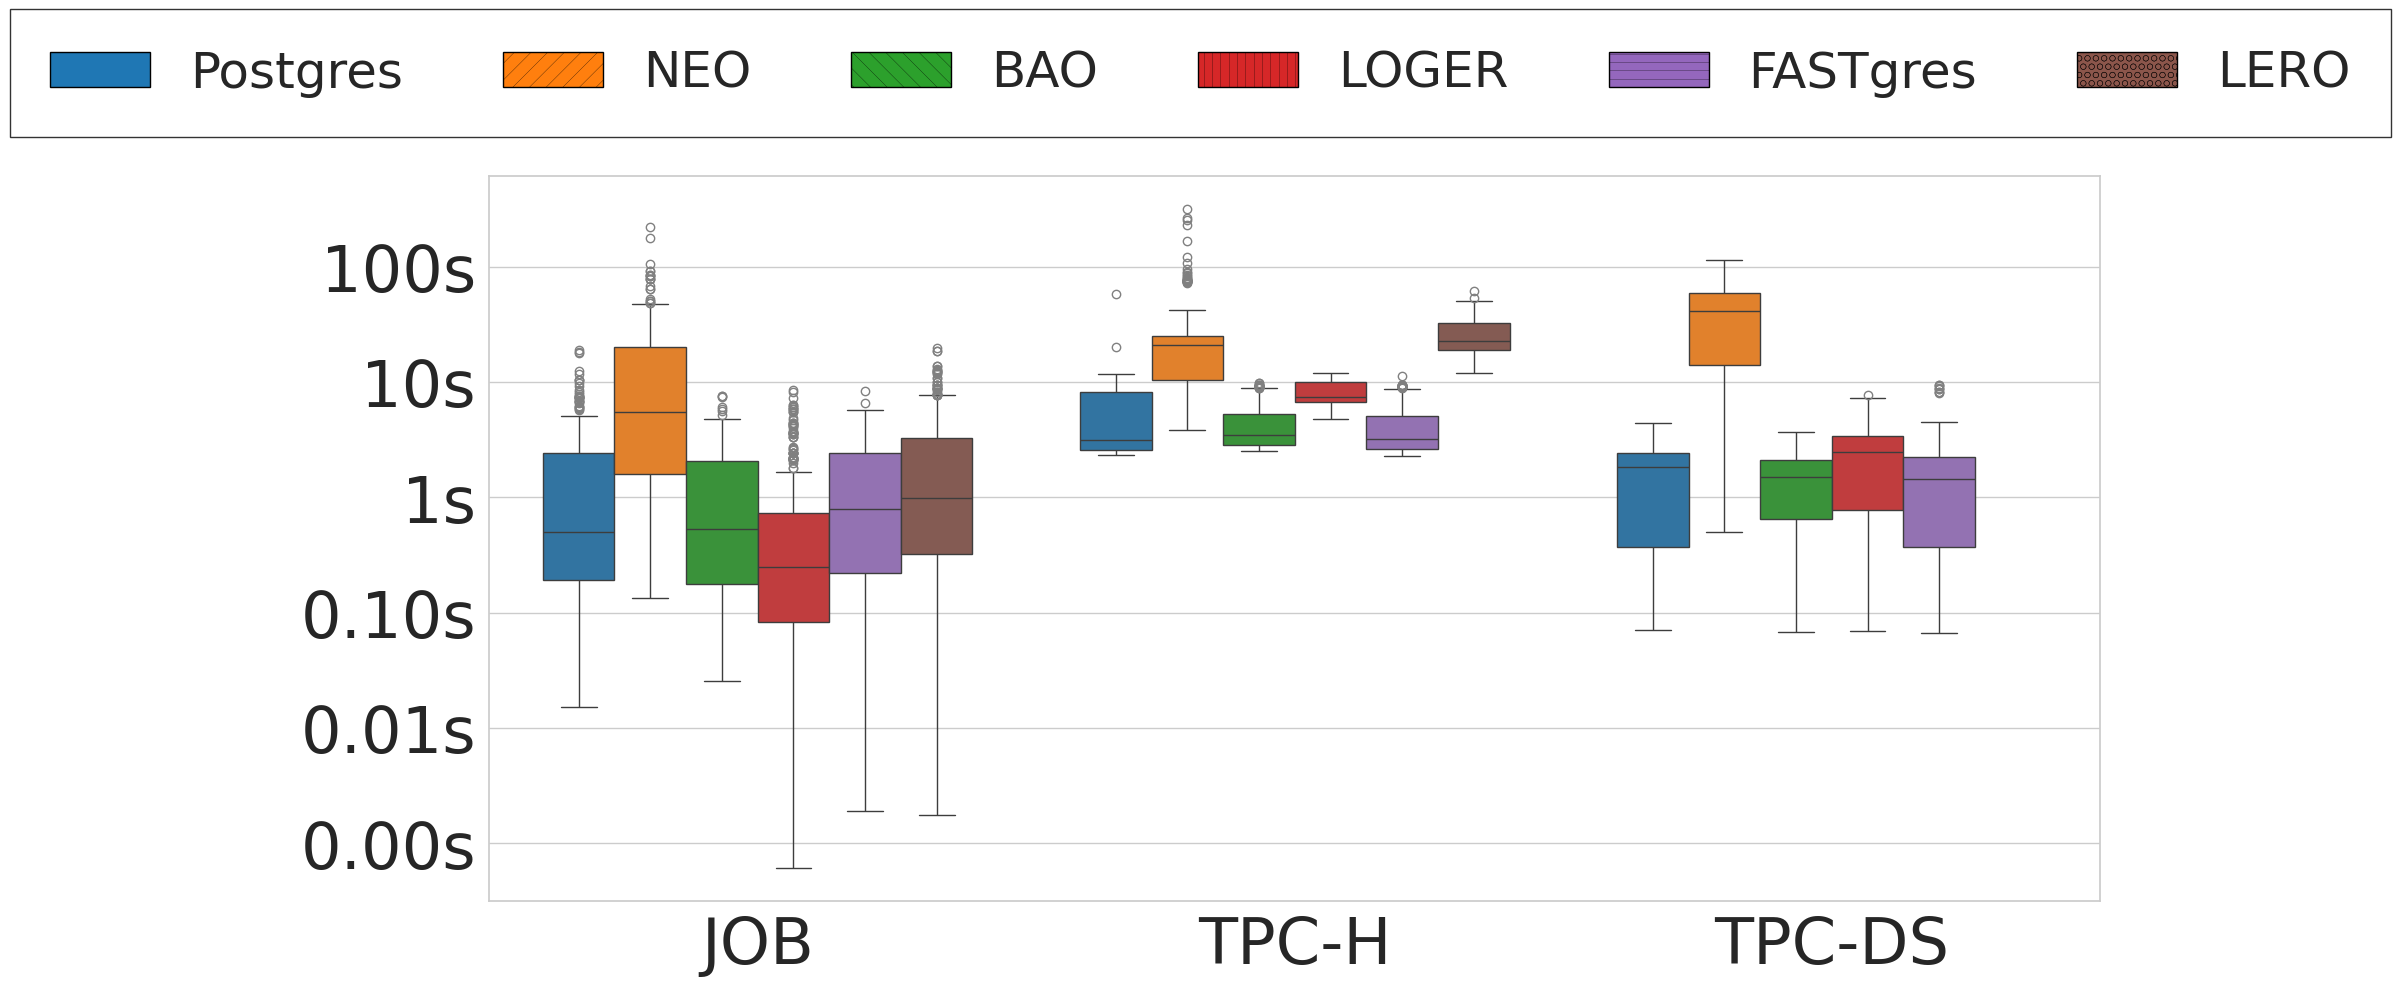

Generating combined Q-Error plot...


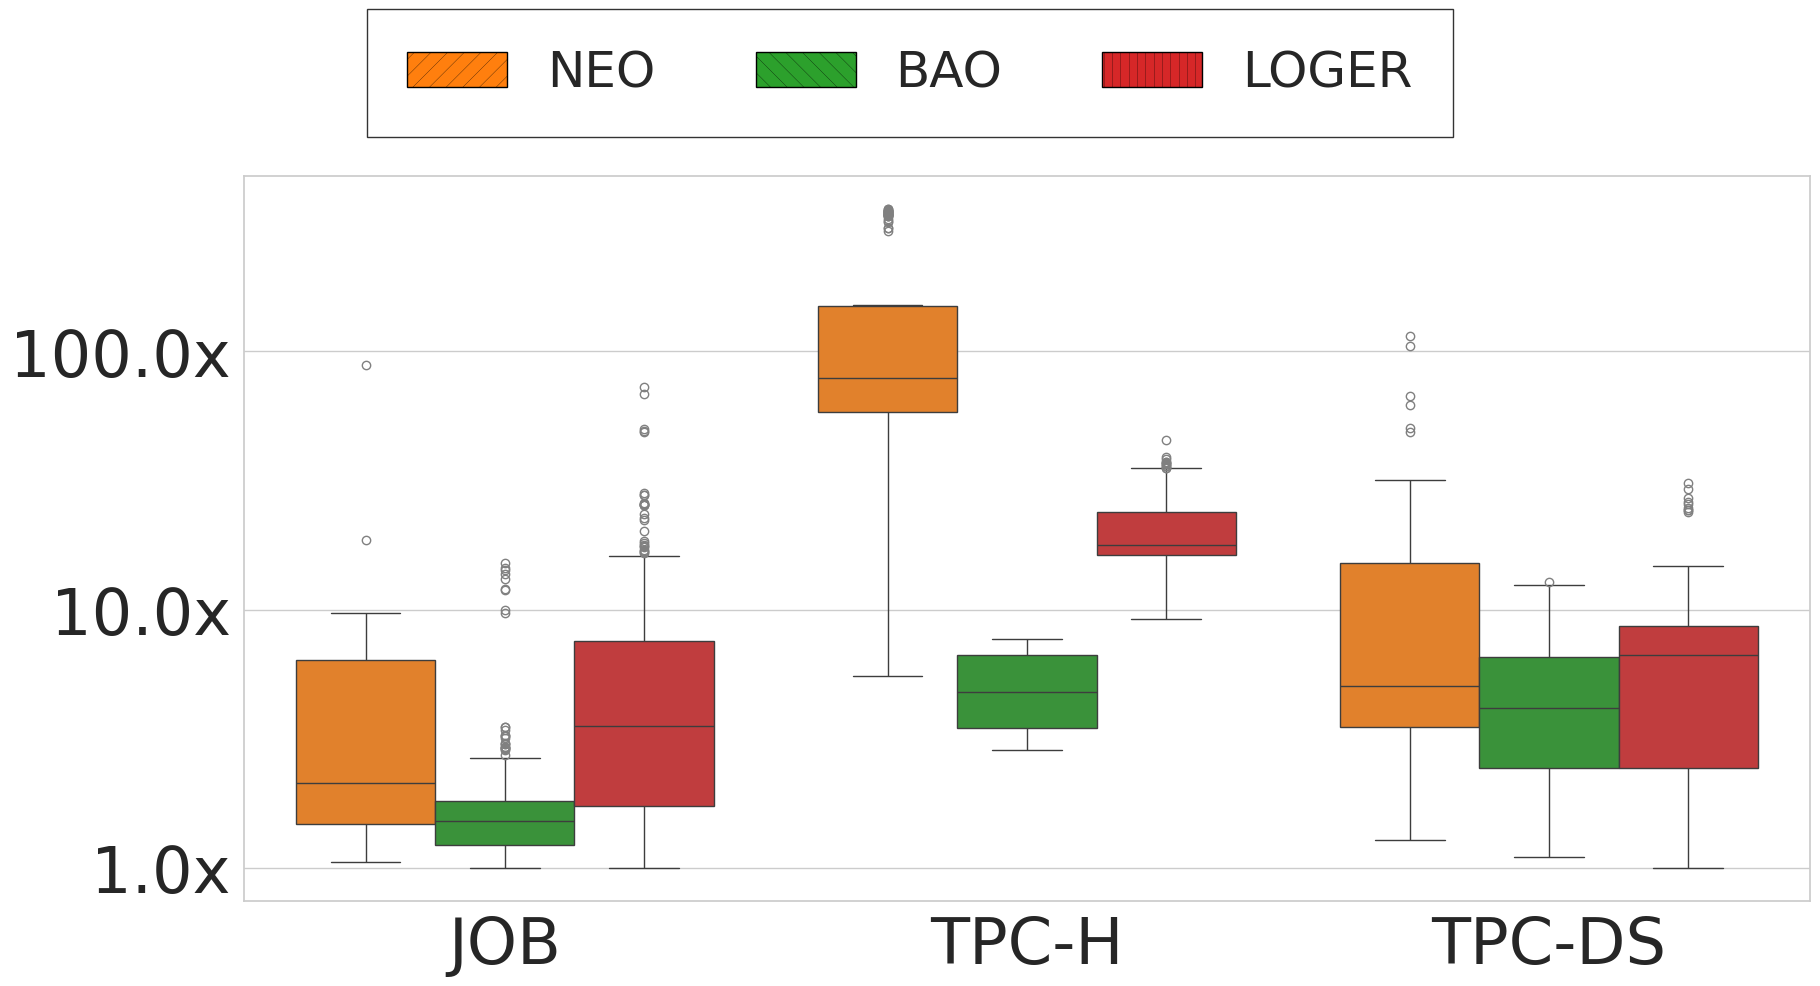

In [24]:
import matplotlib as mpl # <--- ADD THIS IMPORT

def create_combined_boxplot(metric_df, metric_name, y_label, output_file, log_scale=True, selected_optimizers=None):
    opt_list = selected_optimizers if selected_optimizers is not None else sorted(metric_df['Optimizer'].unique())
    benchmark_order = benchmarks
    plt.rcParams.update({'font.size': 26})

    sns.set_theme(style="whitegrid")
    color_map = {optimizer: optimizer_colors[optimizer] for optimizer in opt_list}

    # --- Define the style for hollow outlier markers ---
    flier_props = dict(
        marker='o',              # Marker shape
        markerfacecolor='none',    # Make the inside transparent
        markersize=6,            # The overall diameter of the circle
        markeredgecolor='gray'   # The color of the outline
    )

    fig, ax = plt.subplots(figsize=(18, 8))

    # --- Boxplot with custom hollow outliers ---
    sns.boxplot(
        data=metric_df,
        x='Benchmark',
        y=metric_name,
        hue='Optimizer',
        order=benchmark_order,
        hue_order=opt_list,
        palette=color_map,
        ax=ax,
        flierprops=flier_props # <--- USE THE NEW DICTIONARY HERE
    )

    # --- Hatching logic ---
    for i, artist in enumerate(ax.artists):
        optimizer_idx = i % len(opt_list)
        optimizer_name = opt_list[optimizer_idx]
        artist.set_hatch(patterns.get(optimizer_name, ''))

    # --- Log scale & formatting ---
    if log_scale:
        ax.set_yscale('log')
        ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
        formatter = ticker.FuncFormatter(
            lambda val, pos: f'{val:.2f}s' if 'Time' in y_label and val < 1 else f'{int(val)}s' if 'Time' in y_label else f'{val:.1f}x'
        )
        ax.yaxis.set_major_formatter(formatter)
        ax.yaxis.set_minor_formatter(ticker.NullFormatter())

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', labelsize=46)
    ax.tick_params(axis='y', labelsize=46)

    if ax.get_legend() is not None:
        ax.get_legend().remove()

    # --- Custom Legend with black hatches ---
    legend_handles = [
        mpatches.Patch(facecolor=color_map[opt], hatch=patterns.get(opt, ''), label=opt, edgecolor='black')
        for opt in opt_list
    ]

    fig.legend(
        handles=legend_handles,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.24),
        ncol=len(opt_list),
        frameon=True,
        edgecolor='black',
        fancybox=False,
        borderpad=0.8,
        fontsize=36
    )

    plt.tight_layout(pad=0.0)
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    plt.savefig(output_file, format='pdf', bbox_inches="tight")
    plt.show()
    plt.close(fig)
    
print("Generating combined latency plot...")
create_combined_boxplot(
    metric_df=latency_df,
    metric_name='Latency',
    y_label='Execution Time [s]',
    output_file=os.path.join(output_dir, 'latency_combined_grouped.pdf'),
    selected_optimizers=optimizers
)

print("Generating combined Q-Error plot...")
create_combined_boxplot(
    metric_df=qerror_df,
    metric_name='QError',
    y_label='Q-Error',
    output_file=os.path.join(output_dir, 'qerror_combined_grouped.pdf'),
    selected_optimizers=qerror_optimizers # Use only optimizers that have q-error
)